 # Dupont Analysis for Silicon Valley Bank

 In light of the impending bankruptcy at Silicon Valley Bank. I will revisit
 one of the main lectures learned during my Master of Science in Finance in
 Commercial Banking.

 I will use the latest Call Report from the FFIEC (Federal Financial Institutions
 Examination Council).

 The link to find this is:

 1. Navigate to https://cdr.ffiec.gov/public/ManageFacsimiles.aspx
 2. Select **Call Report**
 3. Type the name of the bank in the **Institution Name** field.
    - After typing you should get a popup window with the report as PDF, with 4
      headers. Click on the one that says **Download SDF**.

    <img width="1720" alt="image" src="https://user-images.githubusercontent.com/13838845/224463271-c58aff90-ca86-4e6a-bf31-c9ac21d1f0f9.png">

 Once you have downloaded the file, you can import it using Pandas function for
 CSV files, just note that the delimiter is a semicolon **;**.

<a href="https://colab.research.google.com/github/danielcs88/dupont_analysis/blob/master/silicon_valley_bank_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment to Install in Colab
# !pip install binarytree

In [2]:
from typing import Union

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from binarytree import build
from IPython.display import display

In [3]:
plt.rcParams["figure.dpi"] = 125
dollar_value = lambda x: f"${x:,.2f}"
rate_value = lambda x: f"{x:.2%}"

In [4]:
prefix = "https://raw.githubusercontent.com/danielcs88/dupont_analysis/master/"

svb = pd.read_csv(f"{prefix}Call_Cert24735_123122.SDF", sep=";")
r_james = pd.read_csv(f"{prefix}Call_Cert33893_123122.SDF", sep=";")
b_united = pd.read_csv(f"{prefix}Call_Cert58979_123122.SDF", sep=";")

In [5]:
def report_date(df: pd.DataFrame) -> str:
    return (
        df.assign(
            **{
                "Call Date": pd.to_datetime(df["Call Date"], format=r"%Y%m%d"),
            }
        )
        .assign(
            formatted_date=lambda d: d["Call Date"].dt.year.astype(str)
            + "-Q"
            + d["Call Date"].dt.quarter.astype(str)
        )["formatted_date"]
        .mode()
        .iloc[0]
    )

In [6]:
def financial_query(df: str, measure: str, measure_float=True) -> Union[float, str]:
    """
    Returns values from queried measure and specified bank DataFrame

    Parameters
    ----------
    df : str
        Name of bank pd.DataFrame which will be eval'ed
    measure : str
        Measure to be sought
    measure_float : TYPE, optional
        Return float result?. The default is True.

    Returns
    -------
    Union[float, str]
        DESCRIPTION.

    """

    df = eval(df)

    if measure_float:
        return float(
            df.loc[df["Short Definition"].str.startswith(measure)]["Value"].unique()[0]
        )
    else:
        return df.loc[df["Short Definition"].str.startswith(measure)]["Value"].iloc[0]

In [7]:
def roe(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return on Equity.
    """
    return financial_query(bank, "Net income") / financial_query(bank, "Total equity")

In [8]:
def roa(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return on Assets.

    """
    return financial_query(bank, "Net income") / financial_query(
        bank, "Total balance sheet assets"
    )

In [9]:
def equity_multiplier(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Equity Multiplier.

    """
    return financial_query(bank, "Total balance sheet assets") / financial_query(
        bank, "Total equity"
    )

In [10]:
def operating_income(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Operating Income.

    """
    interest_income = financial_query(bank, "Total interest income")
    interest_expense = financial_query(bank, "Total interest expense")
    loan_loss_provision = financial_query(bank, "Provision for loan and lease losses")
    non_interest_income = financial_query(bank, "Total noninterest income")
    return sum(
        [
            interest_income,
            -interest_expense,
            -loan_loss_provision,
            non_interest_income,
        ]
    )

In [11]:
def return_on_sales(bank: str) -> float:
    """
    Calculates Return On Sales

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return On Sales.

    """
    return financial_query(bank, "Net income") / operating_income(bank)

In [12]:
def asset_turnover(bank: str) -> float:
    """
    Returns Asset Turnover Rate

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Returns Asset Turnover Rate.

    """
    return operating_income(bank) / financial_query(bank, "Total balance sheet assets")

In [13]:
def dupont_analysis(bank: str) -> None:
    """
    Prints a DuPont Analysis of bank.

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame to be eval'ed.

    """
    values = [
        f"Return on Equity: {rate_value(roe(bank))}",
        f"Equity Multiplier: {equity_multiplier(bank):.2f}",
        f"Return on Assets: {rate_value(roa(bank))}",
        "",
        "",
        f"Asset Turnover: {rate_value(asset_turnover(bank))}",
        f"Return on Sales: {rate_value(return_on_sales(bank))}",
    ]
    root = build(values)
    print(
        f'{financial_query(bank, "Legal title of bank", measure_float=False)} {report_date(eval(bank))}'
    )
    print(root)

In [14]:
print(*map(dupont_analysis, ["svb", "b_united", "r_james"]))

Silicon Valley Bank 2022-Q4

             ____________Return on Equity: 13.10%_________________________________
            /                                                                     \
Equity Multiplier: 13.52                                      __________Return on Assets: 0.97%___________
                                                             /                                            \
                                                  Asset Turnover: 2.60%                         Return on Sales: 37.27%

BankUnited, N.A. 2022-Q4

             ____________Return on Equity: 12.20%_________________________________
            /                                                                     \
Equity Multiplier: 13.29                                      __________Return on Assets: 0.92%___________
                                                             /                                            \
                                                  Asset Turn

In [15]:
def bank_series(bank: str) -> pd.Series:
    bank_dict = {
        "Name": financial_query(bank, "Legal title of bank", measure_float=False),
        "Return on Equity": roe(bank),
        "Equity Multiplier": equity_multiplier(bank),
        "Return on Assets": roa(bank),
        "Asset Turnover": asset_turnover(bank),
        "Return on Sales": return_on_sales(bank),
    }
    return pd.Series(bank_dict)

In [16]:
banks_df = pd.concat(list(map(bank_series, ["svb", "b_united", "r_james"])), axis=1)
banks_df.columns = banks_df.loc["Name"]
banks_df.drop("Name", axis=0, inplace=True)

In [17]:
display(
    banks_df.T.style.format(
        {
            "Return on Equity": "{:.2%}",
            "Equity Multiplier": "{:.2f}",
            "Return on Assets": "{:.2%}",
            "Asset Turnover": "{:.2%}",
            "Return on Sales": "{:.2%}",
        }
    )
)

,Return on Equity,Equity Multiplier,Return on Assets,Asset Turnover,Return on Sales
Name,,,,,
Silicon Valley Bank,13.10%,13.52,0.97%,2.60%,37.27%
"BankUnited, N.A.",12.20%,13.29,0.92%,2.61%,35.21%
Raymond James Bank,22.22%,17.07,1.30%,2.54%,51.31%


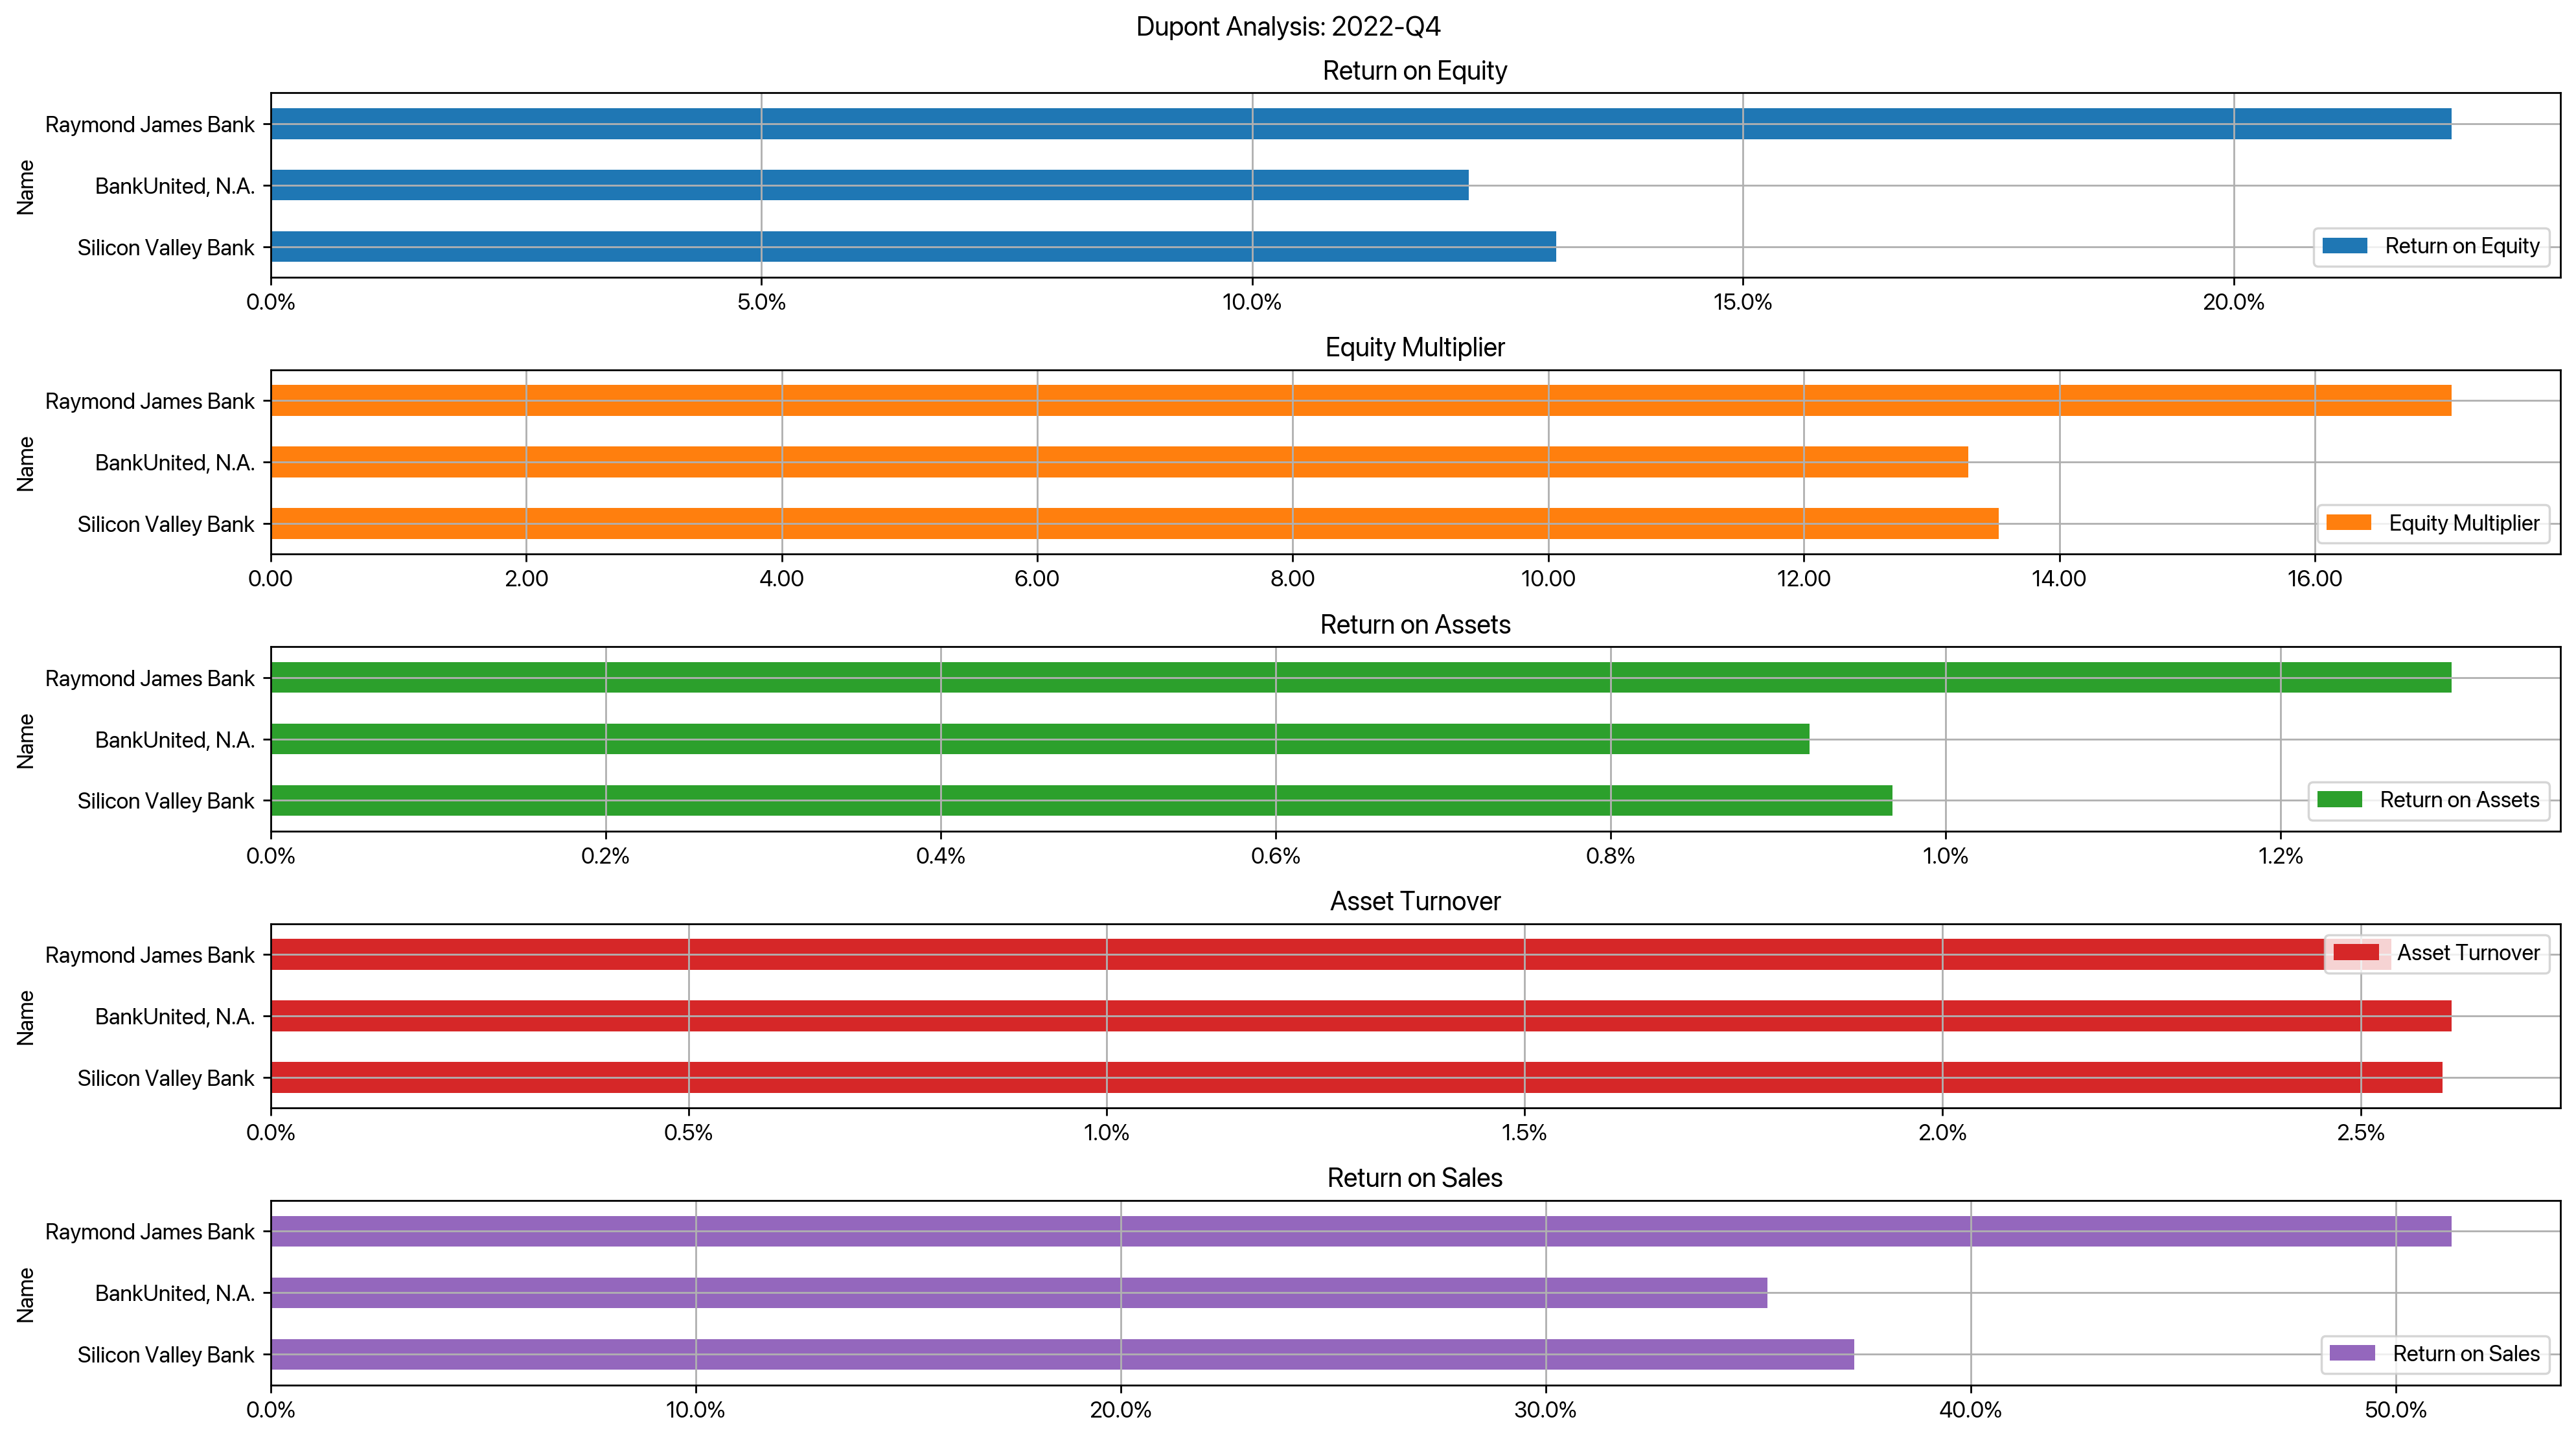

In [18]:
# create the plot
banks_df.T.plot(
    title=f"Dupont Analysis: {set(map(report_date, (svb, r_james, b_united))).pop()}",
    subplots=True,
    kind="barh",
    figsize=(16, 9),
    sharex=False,
    grid=True,
)

# format the x-axis as a percentage for all plots except the second one
for i, ax in enumerate(plt.gcf().axes):
    if i != 1:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1%}"))
    else:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}"))

# adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [19]:
def operating_income_analysis(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Operating Income.

    """
    interest_income = financial_query(bank, "Total interest income")
    interest_expense = financial_query(bank, "Total interest expense")
    loan_loss_provision = financial_query(bank, "Provision for loan and lease losses")
    non_interest_income = financial_query(bank, "Total noninterest income")
    return pd.Series(
        {
            "Name": financial_query(bank, "Legal title of bank", measure_float=False),
            "Total interest income": float(interest_income),
            "Total interest expense": float(-interest_expense),
            "Provision for loan and lease losses": float(-loan_loss_provision),
            "Total noninterest income": float(non_interest_income),
        }
    )

In [20]:
operating_df = pd.concat(
    list(map(operating_income_analysis, ["svb", "b_united", "r_james"])), axis=1
)
operating_df.columns = operating_df.loc["Name"]
operating_df.drop("Name", axis=0, inplace=True)

In [21]:
def display_df_format(DF: Union[pd.DataFrame, pd.Series], float_format: str):
    r"""
    Display pd.DataFrame without changing float format.
    """
    with pd.option_context("display.float_format", float_format.format):
        display(DF)


operating_df.T.pipe(display_df_format, "${:,.0f}")

,Total interest income,Total interest expense,Provision for loan and lease losses,Total noninterest income
Name,,,,
Silicon Valley Bank,"$5,681,000","$-1,097,000","$-420,000","$1,267,000"
"BankUnited, N.A.","$1,227,221","$-280,763","$-75,154","$91,161"
Raymond James Bank,"$1,285,879","$-147,157","$-98,991","$27,808"


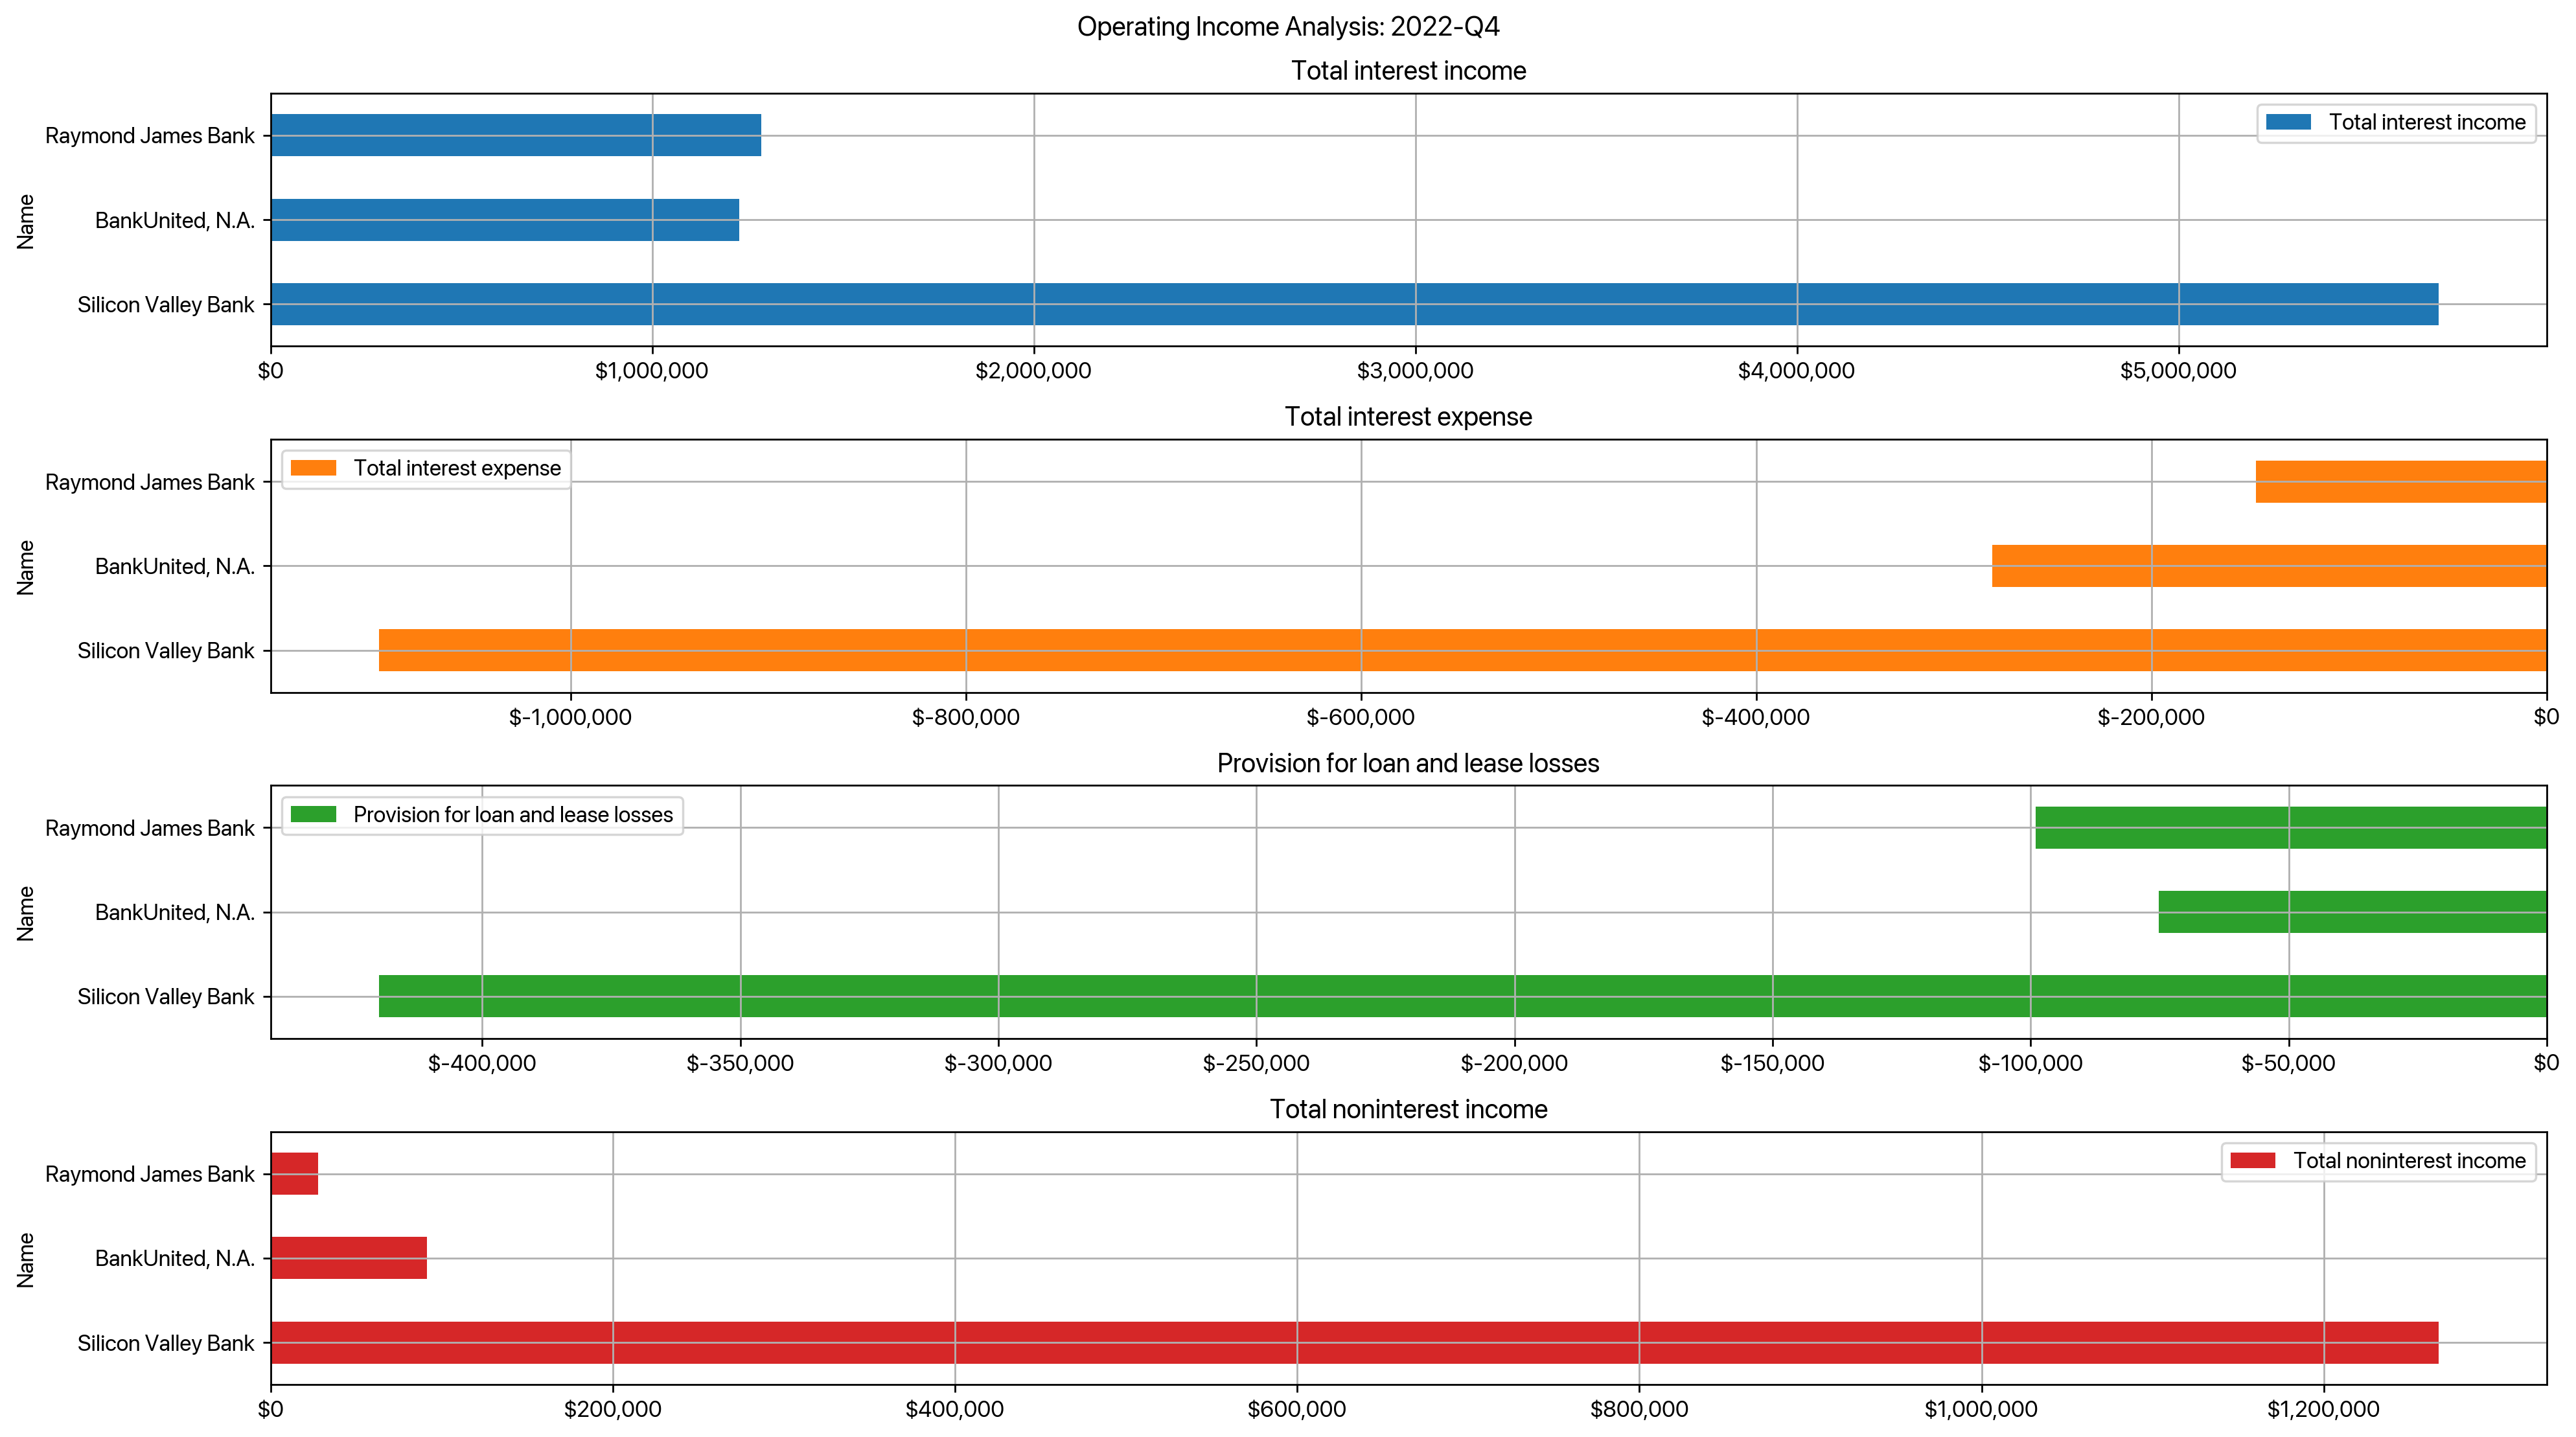

In [22]:
operating_df.T.plot(
    title=f"Operating Income Analysis: {set(map(report_date, (svb, r_james, b_united))).pop()}",
    subplots=True,
    kind="barh",
    figsize=(16, 9),
    sharex=False,
    grid=True,
)


for ax in plt.gcf().axes:
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x:,.0f}"))

# adjust the layout and display the plot
plt.tight_layout()
plt.show()